In [7]:
import pykat
import pylab as pl
import numpy as np
import scipy.signal

In [2]:
kat_code = """
l l1 1 0 n0

s lmod1 1 n0 n1
mod mod1 $f1 0.18 1 pm n1 n2
s lmod2 1 n2 n3
mod mod2 $f2 0.18 1 pm n3 n4
s lmod3 1 n4 n5
mod mod3 $f3 0.18 1 pm n5 nOBAout


tem l1 0 0 0.625 0.0 
tem l1 0 1 0.1 0.0
tem l1 1 0 0.1 0.0
tem l1 1 1 0.075 0.0
tem l1 0 2 0.05 0.0
tem l1 2 0 0.05 0.0


# Distance OBA --> OM1  
s lom1 2.724 nOBAout nOM1a 

#OM1
bs1 OM1 800u $Mloss 0 2.251 nOM1a nOM1b dump dump # T is set for high power; Loss is a guess
attr OM1 Rc 4.6

# Distance OM1 --> OM2
s lom2 1.395 nOM1b nOM2a 

# OM2
bs1 OM2 10u $Mloss 0 4.399 nOM2a nOM2b dump dump  # T is a guess
attr OM2 Rc 1.7058

# Distance OM2 --> OM3
s lom3 0.631 nOM2b nOM3a 
bs1 OM3 10u $Mloss 0 30.037 nOM3a nOM3b nOM3trans dump # T is a guess

# Distance OM3 --> OMC input coupler IC (AR side)
s lom3omc 0.196 nOM3b nOMC_ARIC_in # By design should be ~0.31

#  Distance in transmission to OM3 used for testing
s lomOM3trans 0.1 nOM3trans nOMC_ARIC2_in

###########################################################################
%%% FTend OMCpath 

%%% FTblock OMC
###########################################################################
# OMC (as built parameters: D1300507-v1)

# Input Coupler IC (flat mirror)
bs1 OMC_ARIC 1 0 0 4.004 nOMC_ARIC_in dump nOMC_ARIC_trans dump 
s subOMC_IC 0.01078 $nsilica nOMC_ARIC_trans nOMC_HRIC_in
bs1 OMC_HRIC 0.0076 10u 0 2.7609 nOMC_HRIC_in dump nOMC_HRIC_trans nOMC_HRICret
# Distance from IC to OC 
s OMC_ICOC 0.2815 1 nOMC_HRIC_trans nOMC_HROC_in

# Output Coupler OC (flat mirror)
bs1 OMC_HROC 0.0075 10u 0 4.004 nOMC_HROC_in nOMC_HROC_refl nOMC_HROC_trans nOMC_HROC_ret
s subOMC_OC 0.01078 $nsilica nOMC_HROC_trans nOMC_AROC_in
bs1 OMC_AROC 1 0 0 2.7609 nOMC_AROC_in dump nOMC_AROC_trans dump
# Distance from OC to CM1
s OMC_OCCM1 0.2842 1 nOMC_HROC_refl nOMC_CM1_in

# Curved Mirror CM1
bs1 OMC_CM1 36u 10u 0 4.004 nOMC_CM1_in nOMC_CM1_refl dump dump

# Distance from CM1 to CM2 
s OMC_CM1CM2 0.2815 1 nOMC_CM1_refl nOMC_CM2_in
attr OMC_CM1 Rc 2.57321

# Curved Mirror CM2
bs1 OMC_CM2 35.9u 10u 0 4.004 nOMC_CM2_in nOMC_CM2_refl dump dump
attr OMC_CM2 Rc 2.57369

# Distance from CM2 to IC 
s CM2OC 0.2842 1 nOMC_CM2_refl nOMC_HRICret

const Mloss 37.5u
const nsilica 1.44963098985906
const f1 9.099471M
const nf1 -9.099471M
const f2 45.497355M
const nf2 -45.497355M
const f3 36.497355M
const nf3 -36.497355M

pd OMC_DCPD nOMC_AROC_trans
cp cavOMC x finesse

cav cavOMC OMC_HROC nOMC_HROC_refl OMC_HROC nOMC_HROC_in

xaxis l1 f lin -10M 300M 500
yaxis abs
maxtem 4
"""

In [3]:
#Get the mode of the OMC
basekat = pykat.finesse.kat() 
basekat.parseCommands(kat_code)
kat = basekat.deepcopy()
outOMC = kat.run()

Parsing `tem l1 0 0 0.625 0.0` into pykat object not implemented yet, added as extra line.
Parsing `tem l1 0 1 0.1 0.0` into pykat object not implemented yet, added as extra line.
Parsing `tem l1 1 0 0.1 0.0` into pykat object not implemented yet, added as extra line.
Parsing `tem l1 1 1 0.075 0.0` into pykat object not implemented yet, added as extra line.
Parsing `tem l1 0 2 0.05 0.0` into pykat object not implemented yet, added as extra line.
Parsing `tem l1 2 0 0.05 0.0` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2018-03-02 16:40:02.657581


 91% | ETA:  0:00:00 | Calculating                                             


Finished in 3.41389 seconds


100% | ETA:  0:00:00 | Calculating                                             

In [6]:
### Peak finds
finesse = outOMC['cavOMC_x_finesse'][0]
peak_indices =  scipy.signal.find_peaks_cwt(outOMC['OMC_DCPD'],np.arange(0.1,finesse),min_snr=100)
print(outOMC.x[29])


7980000.0


C:\Users\tvo88\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



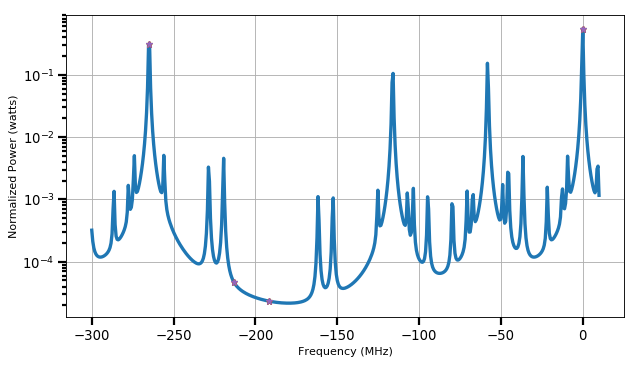

In [11]:
pl.figure(figsize=(9, 5), dpi=80)

pl.semilogy(-outOMC.x/1e6,outOMC['OMC_DCPD'], '-',linewidth=3)
for i in range(len(peak_indices)):
    pl.plot(-outOMC.x[peak_indices]/1e6,outOMC['OMC_DCPD'][peak_indices],'*')


pl.xlabel("Frequency (MHz)")
pl.ylabel("Normalized Power (watts)")

###Main plot formatting
pl.tick_params(labelsize=12)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.show()

In [ ]:
np.savetxt("InModel.txt",[outOMC.x,outOMC['OMC_DCPD']],delimiter=' ')